# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv('data/cleaned_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9067 entries, 0 to 9066
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9067 non-null   int64  
 1   index           9067 non-null   int64  
 2   App             9067 non-null   object 
 3   Category        9067 non-null   object 
 4   Rating          9067 non-null   float64
 5   Reviews         9067 non-null   float64
 6   Size            9067 non-null   float64
 7   Installs        9067 non-null   int64  
 8   Type            9067 non-null   object 
 9   Content Rating  9067 non-null   object 
 10  Last Updated    9067 non-null   object 
 11  Date            9067 non-null   object 
 12  Month           9067 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 921.0+ KB


In [4]:
df.drop(['Unnamed: 0', 'index', 'Last Updated', 'App', 'Date'], axis=1, inplace=True)

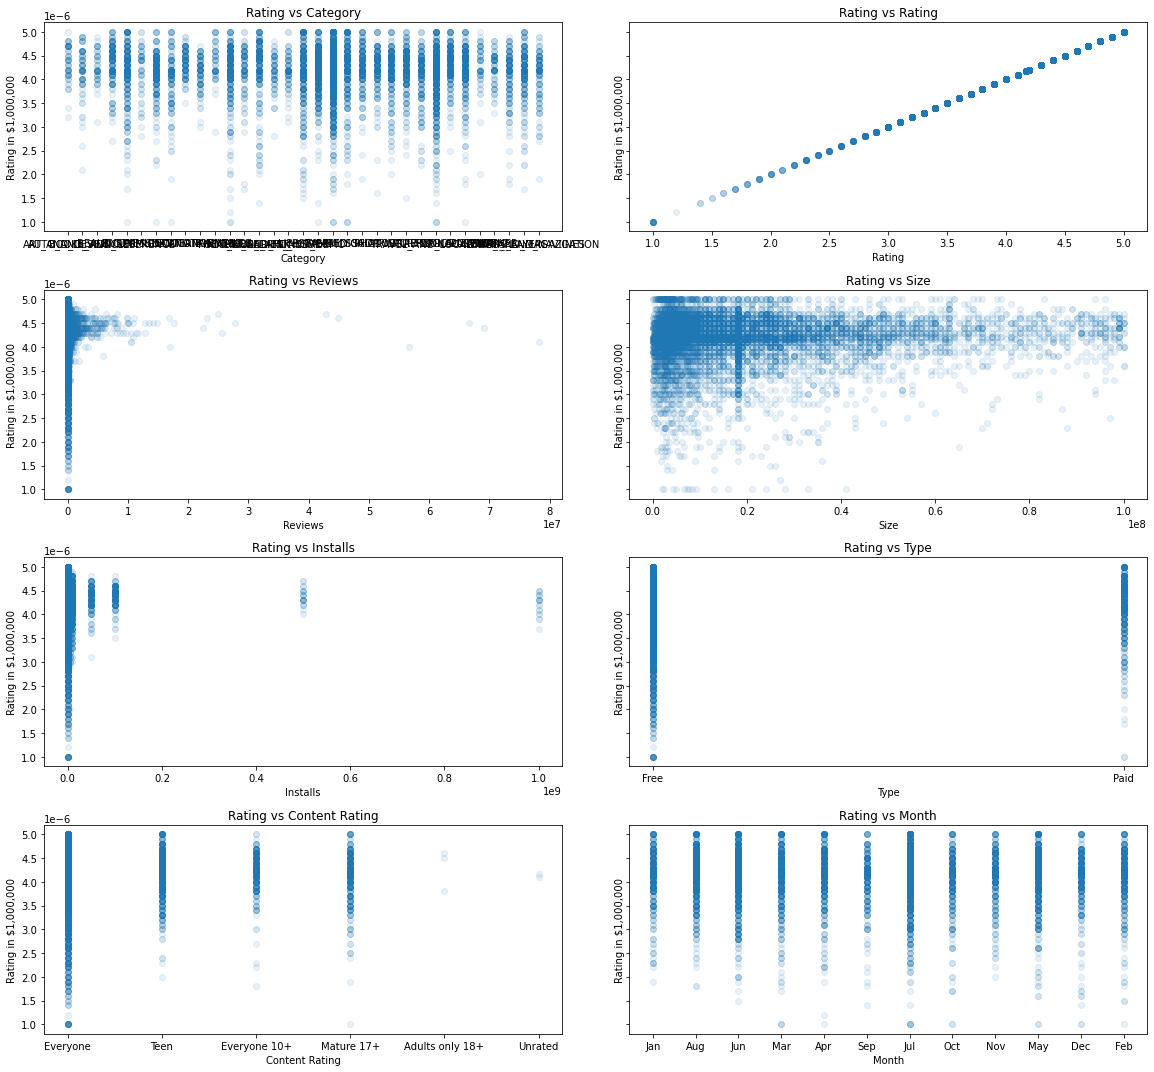

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), df.columns):
    ax.scatter(df[column], df['Rating'] / 1_000_000, label=column, alpha=.1)
    ax.set_title(f'Rating vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Rating in $1,000,000')

fig.tight_layout()

Clearly, the data needs a lot of preprocessing to improve the results. Here you can see the relationship between 'Rating' and the independent variables. We can see what variables are continuous(Reviews, Size, and Installs) and categorical(Category, Type, Content Rating, and Month).

In [6]:
cats = df.select_dtypes(include='object')

In [7]:
cats_dummies = pd.get_dummies(cats, columns=['Category', 'Type', 'Content Rating', 'Month'], drop_first=True)

In [8]:
model_df = pd.concat((df, cats_dummies), axis=1)
model_df.drop(columns=['Category', 'Type', 'Content Rating', 'Month'], axis = 1, inplace=True)
model_df

Rating   Reviews          Size  Installs  Category_AUTO_AND_VEHICLES  \
0     4.100000     159.0  1.900000e+07     10000                           0   
1     3.900000     967.0  1.400000e+07    500000                           0   
2     4.700000   87510.0  8.700000e+06   5000000                           0   
3     4.500000  215644.0  2.500000e+07  50000000                           0   
4     4.300000     967.0  2.800000e+06    100000                           0   
...        ...       ...           ...       ...                         ...   
9062  4.500000      38.0  5.300000e+07      5000                           0   
9063  5.000000       4.0  3.600000e+06       100                           0   
9064  4.172966       3.0  9.500000e+06      1000                           0   
9065  4.500000     114.0  1.811096e+07      1000                           0   
9066  4.500000  398307.0  1.900000e+07  10000000                           0   

      Category_BEAUTY  Category_BOOKS_AND_REFERENCE  Category_BUSINESS  \
0                   0                             0                  0   
1                   0                             0                  0   
2                   0                             0                  0   
3                   0                             0                  0   
4                   0                             0                  0   
...               ...                           ...                ...   
9062                0                             0                  0   
9063                0                             0                  0   
9064                0                             0                  0   
9065                0                             1                  0   
9066                0                             0                  0   

      Category_COMICS  Category_COMMUNICATION  Category_DATING  \
0                   0                       0                0   
1                   0                       0                0   
2                   0                       0                0   
3                   0                       0                0   
4                   0                       0                0   
...               ...                     ...              ...   
9062                0                       0                0   
9063                0                       0                0   
9064                0                       0                0   
9065                0                       0                0   
9066                0                       0                0   

      Category_EDUCATION  Category_ENTERTAINMENT  Category_EVENTS  \
0                      0                       0                0   
1                      0                       0                0   
2                      0                       0                0   
3                      0                       0                0   
4                      0                       0                0   
...                  ...                     ...              ...   
9062                   0                       0                0   
9063                   0                       0                0   
9064                   0                       0                0   
9065                   0                       0                0   
9066                   0                       0                0   

      Category_FAMILY  Category_FINANCE  Category_FOOD_AND_DRINK  \
0                   0                 0                        0   
1                   0                 0                        0   
2                   0                 0                        0   
3                   0                 0                        0   
4                   0                 0                        0   
...               ...               ...                      ...   
9062                1                 0                     

In [9]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9067 entries, 0 to 9066
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rating                        9067 non-null   float64
 1   Reviews                       9067 non-null   float64
 2   Size                          9067 non-null   float64
 3   Installs                      9067 non-null   int64  
 4   Category_AUTO_AND_VEHICLES    9067 non-null   uint8  
 5   Category_BEAUTY               9067 non-null   uint8  
 6   Category_BOOKS_AND_REFERENCE  9067 non-null   uint8  
 7   Category_BUSINESS             9067 non-null   uint8  
 8   Category_COMICS               9067 non-null   uint8  
 9   Category_COMMUNICATION        9067 non-null   uint8  
 10  Category_DATING               9067 non-null   uint8  
 11  Category_EDUCATION            9067 non-null   uint8  
 12  Category_ENTERTAINMENT        9067 non-null   uint8  
 13  Cat

In [10]:
model_df.columns = model_df.columns.str.replace(' ', '_').str.replace('+','')

# Baseline Model

In [11]:
outcome = 'Rating'
predictors = model_df.drop(['Rating'], axis=1)
pred_sum = '+'.join(predictors.columns)
f = outcome + '~' + pred_sum
model = ols(f, model_df).fit()
print(f'List of predictors: {pred_sum}')
display(model.summary())

List of predictors: Reviews+Size+Installs+Category_AUTO_AND_VEHICLES+Category_BEAUTY+Category_BOOKS_AND_REFERENCE+Category_BUSINESS+Category_COMICS+Category_COMMUNICATION+Category_DATING+Category_EDUCATION+Category_ENTERTAINMENT+Category_EVENTS+Category_FAMILY+Category_FINANCE+Category_FOOD_AND_DRINK+Category_GAME+Category_HEALTH_AND_FITNESS+Category_HOUSE_AND_HOME+Category_LIBRARIES_AND_DEMO+Category_LIFESTYLE+Category_MAPS_AND_NAVIGATION+Category_MEDICAL+Category_NEWS_AND_MAGAZINES+Category_PARENTING+Category_PERSONALIZATION+Category_PHOTOGRAPHY+Category_PRODUCTIVITY+Category_SHOPPING+Category_SOCIAL+Category_SPORTS+Category_TOOLS+Category_TRAVEL_AND_LOCAL+Category_VIDEO_PLAYERS+Category_WEATHER+Type_Paid+Content_Rating_Everyone+Content_Rating_Everyone_10+Content_Rating_Mature_17+Content_Rating_Teen+Content_Rating_Unrated+Month_Aug+Month_Dec+Month_Feb+Month_Jan+Month_Jul+Month_Jun+Month_Mar+Month_May+Month_Nov+Month_Oct+Month_Sep


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     8.540
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           7.95e-62
Time:                        22:15:34   Log-Likelihood:                -6555.2
No. Observations:                9067   AIC:                         1.322e+04
Df Residuals:                    9014   BIC:                         1.359e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.3687      0.300     14.567      0.000       3.781       4.957
Reviews                       1.037e-08   3.58e-09      2.894      0.004    3.35e-09    1.74e-08
Size                           3.27e-10   2.86e-10      1.144      0.253   -2.33e-10    8.87e-10
Installs                      3.607e-11   1.23e-10      0.294      0.769   -2.04e-10    2.77e-10
Category_AUTO_AND_VEHICLES      -0.1885      0.084     -2.241      0.025      -0.353      -0.024
Category_BEAUTY                 -0.0812      0.094     -0.861      0.389      -0.266       0.104
Category_BOOKS_AND_REFERENCE    -0.0198      0.072     -0.274      0.784      -0.162       0.122
Category_BUSINESS               -0.2260      0.069     -3.293      0.001      -0.360      -0.091
Category_COMICS                 -0.1898      0.093     -2.046      0.041      -0.372      -0.008
Category_COMMUNICATION          -0.2493      0.070     -3.574      0.000      -0.386      -0.113
Category_DATING                 -0.3859      0.081     -4.785      0.000      -0.544      -0.228
Category_EDUCATION               0.0075      0.078      0.096      0.923      -0.145       0.161
Category_ENTERTAINMENT          -0.2641      0.081     -3.266      0.001      -0.423      -0.106
Category_EVENTS                  0.0197      0.091      0.216      0.829      -0.159       0.198
Category_FAMILY                 -0.1711      0.064     -2.658      0.008      -0.297      -0.045
Category_FINANCE                -0.2411      0.069     -3.502      0.000      -0.376      -0.106
Category_FOOD_AND_DRINK         -0.2063      0.080     -2.576      0.010      -0.363      -0.049
Category_GAME                   -0.1283      0.066     -1.949      0.051      -0.257       0.001
Category_HEALTH_AND_FITNESS     -0.1377      0.070     -1.961      0.050      -0.275   -2.35e-05
Category_HOUSE_AND_HOME         -0.2278      0.087     -2.611      0.009      -0.399      -0.057
Category_LIBRARIES_AND_DEMO     -0.1382      0.084     -1.642      0.101      -0.303       0.027
Category_LIFESTYLE              -0.2479      0.069     -3.608      0.000      -0.383      -0.113
Category_MAPS_AND_NAVIGATION    -0.3226      0.077     -4.181      0.000      -0.474      -0.171
Category_MEDICAL                -0.2002      0.069     -2.907      0.004      -0.335      -0.065
Category_NEWS_AND_MAGAZINES     -0.2393      0.071     -3.362      0.001      -0.379      -0.100
Category_PARENTING              -0.0831      0.090     -0.920      0.358      -0.260       0.094
Category_PERSONALIZATION        -0.0417      0.069     -0.608      0.543      -0.176       0.093
Category_PHOTOGRAPHY            -0.2007      0.070     -2.870      0.004      -0.338      -0.064
Category_PRODUCTIVITY           -0.1696      0.069     -2.467      0.014    

In [12]:
y = model_df['Rating']
X = model_df.drop('Rating', axis=1)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(len(X_train), len(X_test), len(y_train), len(y_test))

6800 2267 6800 2267


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
linreg = LinearRegression()

In [15]:
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('MAE:', mean_absolute_error(y_test, y_hat_test))
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)
print('Root Mean Squared Error Train:', rmse_train)
print('Root Mean Squared Error Test:', rmse_test)

MAE: 0.33870338677603556
Train Mean Squared Error: 0.25326027177065313
Test Mean Squared Error: 0.23618161751536626
Root Mean Squared Error Train: 0.503249711148107
Root Mean Squared Error Test: 0.48598520297985026


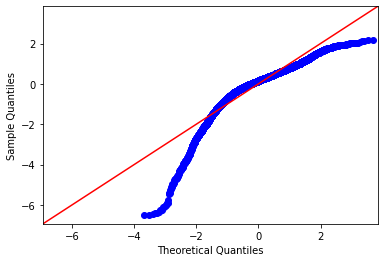

In [16]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

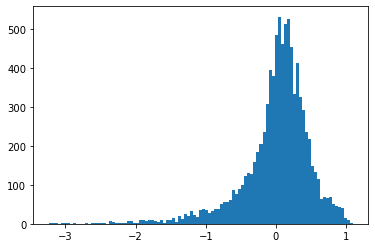

In [17]:
plt.hist(residuals, bins='auto');

# Outliers

In [18]:
from numpy import mean
from numpy import std

<AxesSubplot:xlabel='Reviews'>

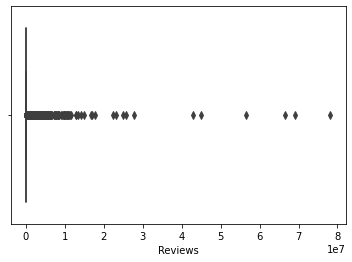

In [19]:
sns.boxplot(x=model_df['Reviews'])

In [20]:
def outliers(col, df):
    mean = df[col].mean()
    std = df[col].std()
    cut_off = std * 3
    lower = mean - cut_off
    upper = mean + cut_off
    outliers = [x for x in df[col] if x < lower or x > upper]
    return sorted(outliers)

In [21]:
outliers('Reviews', model_df)

[5916606.0,
 6012719.0,
 6074334.0,
 6120977.0,
 6181640.0,
 6198563.0,
 6207063.0,
 6210998.0,
 6289924.0,
 6427773.0,
 6466641.0,
 6474426.0,
 6702776.0,
 7165362.0,
 7232629.0,
 7464996.0,
 7529865.0,
 7594559.0,
 7614130.0,
 7671249.0,
 7790693.0,
 7820209.0,
 8033493.0,
 8118609.0,
 8118880.0,
 8190074.0,
 8219586.0,
 8389714.0,
 8606259.0,
 8923587.0,
 9235155.0,
 9642995.0,
 9879473.0,
 9881829.0,
 9882639.0,
 10053186.0,
 10055521.0,
 10216538.0,
 10424925.0,
 10484169.0,
 10485308.0,
 10790289.0,
 10858556.0,
 10979062.0,
 11334799.0,
 11667403.0,
 12759663.0,
 12842860.0,
 13479633.0,
 14198297.0,
 14891223.0,
 16771865.0,
 17014787.0,
 17712922.0,
 22426677.0,
 23133508.0,
 24900999.0,
 25655305.0,
 27722264.0,
 42916526.0,
 44891723.0,
 56642847.0,
 66577313.0,
 69119316.0,
 78158306.0]

In [22]:
model_out = model_df[(model_df['Reviews'] <= 5916606) & (model_df['Reviews'] >= 100)]
model_out.reset_index()

index  Rating   Reviews          Size  Installs  \
0         0     4.1     159.0  1.900000e+07     10000   
1         1     3.9     967.0  1.400000e+07    500000   
2         2     4.7   87510.0  8.700000e+06   5000000   
3         3     4.5  215644.0  2.500000e+07  50000000   
4         4     4.3     967.0  2.800000e+06    100000   
...     ...     ...       ...           ...       ...   
6263   9056     4.6     603.0  7.400000e+06     10000   
6264   9057     3.8     881.0  2.300000e+06    100000   
6265   9059     3.8    1195.0  5.820000e+05    100000   
6266   9065     4.5     114.0  1.811096e+07      1000   
6267   9066     4.5  398307.0  1.900000e+07  10000000   

      Category_AUTO_AND_VEHICLES  Category_BEAUTY  \
0                              0                0   
1                              0                0   
2                              0                0   
3                              0                0   
4                              0                0   
...                          ...              ...   
6263                           0                0   
6264                           0                0   
6265                           0                0   
6266                           0                0   
6267                           0                0   

      Category_BOOKS_AND_REFERENCE  Category_BUSINESS  Category_COMICS  \
0                                0                  0                0   
1                                0                  0                0   
2                                0                  0                0   
3                                0                  0                0   
4                                0                  0                0   
...                            ...                ...              ...   
6263                             1                  0                0   
6264                             0                  0                0   
6265                             0                  0                0   
6266                             1                  0                0   
6267                             0                  0                0   

      Category_COMMUNICATION  Category_DATING  Category_EDUCATION  \
0                          0                0                   0   
1                          0                0                   0   
2                          0                0                   0   
3                          0                0                   0   
4                          0                0                   0   
...                      ...              ...                 ...   
6263                       0                0                   0   
6264                       0                0                   0   
6265                       0                0                   0   
6266                       0                0                   0   
6267                       0                0                   0   

      Category_ENTERTAINMENT  Category_EVENTS  Category_FAMILY  \
0                          0                0                0   
1                          0                0                0   
2                          0                0                0   
3                          0                0                0   
4                          0                0                0   
...                      ...              ...              ...   
6263                       0                0                0   
6264                       0                0                0   
6265                       0                0                0   
6266                       0                0                0   
6267                       0                0                0   

      Category_FINANCE  Category_FOOD_AND_DRINK  Category_GAME  \
0                    0                        0              0   
1                    0                   

<AxesSubplot:xlabel='Installs'>

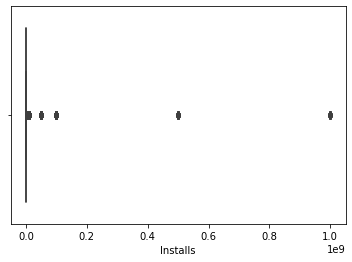

In [23]:
sns.boxplot(x=model_df['Installs'])

In [24]:
outliers('Installs', model_out)

[500000000,
 500000000,
 500000000,
 500000000,
 500000000,
 500000000,
 500000000,
 500000000,
 500000000,
 500000000,
 1000000000,
 1000000000,
 1000000000,
 1000000000,
 1000000000,
 1000000000,
 1000000000,
 1000000000]

In [59]:
model_out = model_out[(model_out['Installs'] < 50000000) & (model_out['Installs'] >= 1000)]
model_out.reset_index()

index  Rating   Reviews          Size  Installs  \
0         0     4.1     159.0  1.900000e+07     10000   
1         1     3.9     967.0  1.400000e+07    500000   
2         2     4.7   87510.0  8.700000e+06   5000000   
3         4     4.3     967.0  2.800000e+06    100000   
4         5     4.4     167.0  5.600000e+06     50000   
...     ...     ...       ...           ...       ...   
5745   9056     4.6     603.0  7.400000e+06     10000   
5746   9057     3.8     881.0  2.300000e+06    100000   
5747   9059     3.8    1195.0  5.820000e+05    100000   
5748   9065     4.5     114.0  1.811096e+07      1000   
5749   9066     4.5  398307.0  1.900000e+07  10000000   

      Category_AUTO_AND_VEHICLES  Category_BEAUTY  \
0                              0                0   
1                              0                0   
2                              0                0   
3                              0                0   
4                              0                0   
...                          ...              ...   
5745                           0                0   
5746                           0                0   
5747                           0                0   
5748                           0                0   
5749                           0                0   

      Category_BOOKS_AND_REFERENCE  Category_BUSINESS  Category_COMICS  \
0                                0                  0                0   
1                                0                  0                0   
2                                0                  0                0   
3                                0                  0                0   
4                                0                  0                0   
...                            ...                ...              ...   
5745                             1                  0                0   
5746                             0                  0                0   
5747                             0                  0                0   
5748                             1                  0                0   
5749                             0                  0                0   

      Category_COMMUNICATION  Category_DATING  Category_EDUCATION  \
0                          0                0                   0   
1                          0                0                   0   
2                          0                0                   0   
3                          0                0                   0   
4                          0                0                   0   
...                      ...              ...                 ...   
5745                       0                0                   0   
5746                       0                0                   0   
5747                       0                0                   0   
5748                       0                0                   0   
5749                       0                0                   0   

      Category_ENTERTAINMENT  Category_EVENTS  Category_FAMILY  \
0                          0                0                0   
1                          0                0                0   
2                          0                0                0   
3                          0                0                0   
4                          0                0                0   
...                      ...              ...              ...   
5745                       0                0                0   
5746                       0                0                0   
5747                       0                0                0   
5748                       0                0                0   
5749                       0                0                0   

      Category_FINANCE  Category_FOOD_AND_DRINK  Category_GAME  \
0                    0                        0              0   
1                    0                   

<AxesSubplot:xlabel='Installs'>

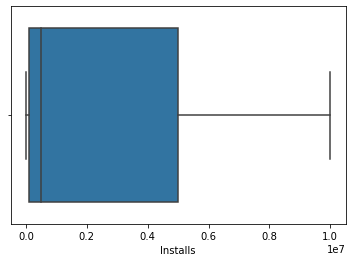

In [60]:
sns.boxplot(x=model_out['Installs'])

<AxesSubplot:xlabel='Size'>

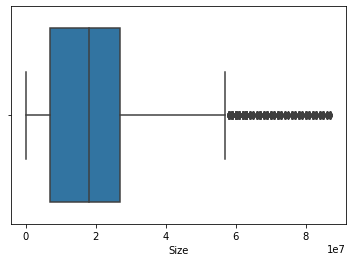

In [61]:
sns.boxplot(x=model_out['Size'])

In [62]:
outliers('Size', model_out)

[77000000.0,
 77000000.0,
 77000000.0,
 77000000.0,
 77000000.0,
 77000000.0,
 77000000.0,
 77000000.0,
 77000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 78000000.0,
 79000000.0,
 79000000.0,
 79000000.0,
 79000000.0,
 79000000.0,
 79000000.0,
 79000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 80000000.0,
 81000000.0,
 81000000.0,
 81000000.0,
 81000000.0,
 81000000.0,
 81000000.0,
 81000000.0,
 81000000.0,
 81000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 82000000.0,
 83000000.0,
 83000000.0,
 83000000.0,
 83000000.0,
 83000000.0,
 83000000.0,
 83000000.0,
 83000000.0,
 83000000.0,
 83000000.0,
 84000000.0,
 84000000.0,
 84000000.0,
 84000000.0,
 84000000.0,

In [63]:
model_out = model_out[(model_out['Size'] < 77000000)]
model_out.reset_index()

index  Rating   Reviews          Size  Installs  \
0         0     4.1     159.0  1.900000e+07     10000   
1         1     3.9     967.0  1.400000e+07    500000   
2         2     4.7   87510.0  8.700000e+06   5000000   
3         4     4.3     967.0  2.800000e+06    100000   
4         5     4.4     167.0  5.600000e+06     50000   
...     ...     ...       ...           ...       ...   
5640   9056     4.6     603.0  7.400000e+06     10000   
5641   9057     3.8     881.0  2.300000e+06    100000   
5642   9059     3.8    1195.0  5.820000e+05    100000   
5643   9065     4.5     114.0  1.811096e+07      1000   
5644   9066     4.5  398307.0  1.900000e+07  10000000   

      Category_AUTO_AND_VEHICLES  Category_BEAUTY  \
0                              0                0   
1                              0                0   
2                              0                0   
3                              0                0   
4                              0                0   
...                          ...              ...   
5640                           0                0   
5641                           0                0   
5642                           0                0   
5643                           0                0   
5644                           0                0   

      Category_BOOKS_AND_REFERENCE  Category_BUSINESS  Category_COMICS  \
0                                0                  0                0   
1                                0                  0                0   
2                                0                  0                0   
3                                0                  0                0   
4                                0                  0                0   
...                            ...                ...              ...   
5640                             1                  0                0   
5641                             0                  0                0   
5642                             0                  0                0   
5643                             1                  0                0   
5644                             0                  0                0   

      Category_COMMUNICATION  Category_DATING  Category_EDUCATION  \
0                          0                0                   0   
1                          0                0                   0   
2                          0                0                   0   
3                          0                0                   0   
4                          0                0                   0   
...                      ...              ...                 ...   
5640                       0                0                   0   
5641                       0                0                   0   
5642                       0                0                   0   
5643                       0                0                   0   
5644                       0                0                   0   

      Category_ENTERTAINMENT  Category_EVENTS  Category_FAMILY  \
0                          0                0                0   
1                          0                0                0   
2                          0                0                0   
3                          0                0                0   
4                          0                0                0   
...                      ...              ...              ...   
5640                       0                0                0   
5641                       0                0                0   
5642                       0                0                0   
5643                       0                0                0   
5644                       0                0                0   

      Category_FINANCE  Category_FOOD_AND_DRINK  Category_GAME  \
0                    0                        0              0   
1                    0                   

In [58]:
model_out.describe()

Rating       Reviews          Size      Installs  \
count  5753.000000  5.753000e+03  5.753000e+03  5.753000e+03   
mean      4.184722  7.361625e+04  2.108607e+07  2.376298e+06   
std       0.432097  1.944494e+05  1.851078e+07  3.574554e+06   
min       1.600000  1.000000e+02  8.500000e+03  5.000000e+02   
25%       4.000000  8.980000e+02  7.000000e+06  1.000000e+05   
50%       4.300000  7.881000e+03  1.811096e+07  5.000000e+05   
75%       4.500000  5.126900e+04  2.700000e+07  5.000000e+06   
max       5.000000  3.093358e+06  8.700000e+07  1.000000e+07   

       Category_AUTO_AND_VEHICLES  Category_BEAUTY  \
count                 5753.000000      5753.000000   
mean                     0.009560         0.005562   
std                      0.097316         0.074380   
min                      0.000000         0.000000   
25%                      0.000000         0.000000   
50%                      0.000000         0.000000   
75%                      0.000000         0.000000   
max                      1.000000         1.000000   

       Category_BOOKS_AND_REFERENCE  Category_BUSINESS  Category_COMICS  \
count                   5753.000000        5753.000000      5753.000000   
mean                       0.020337           0.023987         0.008343   
std                        0.141163           0.153023         0.090969   
min                        0.000000           0.000000         0.000000   
25%                        0.000000           0.000000         0.000000   
50%                        0.000000           0.000000         0.000000   
75%                        0.000000           0.000000         0.000000   
max                        1.000000           1.000000         1.000000   

       Category_COMMUNICATION  Category_DATING  Category_EDUCATION  \
count             5753.000000      5753.000000         5753.000000   
mean                 0.028855         0.017730            0.019816   
std                  0.167412         0.131979            0.139379   
min                  0.000000         0.000000            0.000000   
25%                  0.000000         0.000000            0.000000   
50%                  0.000000         0.000000            0.000000   
75%                  0.000000         0.000000            0.000000   
max                  1.000000         1.000000            1.000000   

       Category_ENTERTAINMENT  Category_EVENTS  Category_FAMILY  \
count             5753.000000      5753.000000      5753.000000   
mean                 0.015818         0.004693         0.191900   
std                  0.124781         0.068352         0.393829   
min                  0.000000         0.000000         0.000000   
25%                  0.000000         0.000000         0.000000   
50%                  0.000000         0.000000         0.000000   
75%                  0.000000         0.000000         0.000000   
max                  1.000000         1.000000         1.000000   

       Category_FINANCE  Category_FOOD_AND_DRINK  Category_GAME  \
count       5753.000000              5753.000000     5753.00000   
mean           0.038241                 0.014427        0.11368   
std            0.191794                 0.119254        0.31745   
min            0.000000                 0.000000        0.00000   
25%            0.000000                 0.000000        0.00000   
50%            0.000000                 0.000000        0.00000   
75%            0.000000                 0.000000        0.00000   
max            1.000000                 1.000000        1.00000   

       Category_HEALTH_AND_FITNESS  Category_HOUSE_AND_HOME  \
count                  5753.000000              5753.000000   
mean                      0.033722                 0.010603   
std                       0.180527                 0.102433   
min                       0.000000                 0.000000   
25%                       0.000000                 0.000000   
50%                       0.000000                 0.00

# Model - Outliers Fixed

In [64]:
outcome = 'Rating'
predictors = model_out.drop(['Rating'], axis=1)
pred_sum = '+'.join(predictors.columns)
f = outcome + '~' + pred_sum
model = ols(f, model_out).fit()
print(f'List of predictors: {pred_sum}')
display(model.summary())

List of predictors: Reviews+Size+Installs+Category_AUTO_AND_VEHICLES+Category_BEAUTY+Category_BOOKS_AND_REFERENCE+Category_BUSINESS+Category_COMICS+Category_COMMUNICATION+Category_DATING+Category_EDUCATION+Category_ENTERTAINMENT+Category_EVENTS+Category_FAMILY+Category_FINANCE+Category_FOOD_AND_DRINK+Category_GAME+Category_HEALTH_AND_FITNESS+Category_HOUSE_AND_HOME+Category_LIBRARIES_AND_DEMO+Category_LIFESTYLE+Category_MAPS_AND_NAVIGATION+Category_MEDICAL+Category_NEWS_AND_MAGAZINES+Category_PARENTING+Category_PERSONALIZATION+Category_PHOTOGRAPHY+Category_PRODUCTIVITY+Category_SHOPPING+Category_SOCIAL+Category_SPORTS+Category_TOOLS+Category_TRAVEL_AND_LOCAL+Category_VIDEO_PLAYERS+Category_WEATHER+Type_Paid+Content_Rating_Everyone+Content_Rating_Everyone_10+Content_Rating_Mature_17+Content_Rating_Teen+Content_Rating_Unrated+Month_Aug+Month_Dec+Month_Feb+Month_Jan+Month_Jul+Month_Jun+Month_Mar+Month_May+Month_Nov+Month_Oct+Month_Sep


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     11.87
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           6.83e-92
Time:                        22:44:03   Log-Likelihood:                -2997.6
No. Observations:                5645   AIC:                             6101.
Df Residuals:                    5592   BIC:                             6453.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.3862      0.250     17.521      0.000       3.895       4.877
Reviews                       3.126e-07   3.68e-08      8.497      0.000     2.4e-07    3.85e-07
Size                          4.279e-10   3.71e-10      1.153      0.249      -3e-10    1.16e-09
Installs                      5.158e-09   2.05e-09      2.520      0.012    1.15e-09    9.17e-09
Category_AUTO_AND_VEHICLES      -0.0636      0.081     -0.789      0.430      -0.221       0.094
Category_BEAUTY                 -0.0058      0.093     -0.062      0.951      -0.189       0.177
Category_BOOKS_AND_REFERENCE     0.0526      0.070      0.756      0.450      -0.084       0.189
Category_BUSINESS               -0.2098      0.068     -3.092      0.002      -0.343      -0.077
Category_COMICS                 -0.1871      0.084     -2.218      0.027      -0.353      -0.022
Category_COMMUNICATION          -0.2695      0.066     -4.060      0.000      -0.400      -0.139
Category_DATING                 -0.3573      0.079     -4.552      0.000      -0.511      -0.203
Category_EDUCATION              -0.0059      0.070     -0.084      0.933      -0.143       0.131
Category_ENTERTAINMENT          -0.2740      0.074     -3.721      0.000      -0.418      -0.130
Category_EVENTS                 -0.0234      0.099     -0.237      0.812      -0.217       0.170
Category_FAMILY                 -0.2182      0.060     -3.656      0.000      -0.335      -0.101
Category_FINANCE                -0.2179      0.064     -3.379      0.001      -0.344      -0.091
Category_FOOD_AND_DRINK         -0.1745      0.074     -2.367      0.018      -0.319      -0.030
Category_GAME                   -0.1734      0.061     -2.829      0.005      -0.294      -0.053
Category_HEALTH_AND_FITNESS     -0.0896      0.065     -1.372      0.170      -0.218       0.038
Category_HOUSE_AND_HOME         -0.1902      0.079     -2.411      0.016      -0.345      -0.036
Category_LIBRARIES_AND_DEMO     -0.1701      0.085     -1.993      0.046      -0.337      -0.003
Category_LIFESTYLE              -0.3116      0.065     -4.789      0.000      -0.439      -0.184
Category_MAPS_AND_NAVIGATION    -0.2684      0.074     -3.639      0.000      -0.413      -0.124
Category_MEDICAL                -0.1632      0.068     -2.397      0.017      -0.297      -0.030
Category_NEWS_AND_MAGAZINES     -0.2827      0.068     -4.186      0.000      -0.415      -0.150
Category_PARENTING              -0.0341      0.088     -0.387      0.699      -0.207       0.139
Category_PERSONALIZATION        -0.0695      0.065     -1.066      0.286      -0.197       0.058
Category_PHOTOGRAPHY            -0.2392      0.066     -3.638      0.000      -0.368      -0.110
Category_PRODUCTIVITY           -0.1387      0.065     -2.130      0.033    

In [65]:
y = model_out['Rating']
X = model_out.drop('Rating', axis=1)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(len(X_train), len(X_test), len(y_train), len(y_test))

4233 1412 4233 1412


In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
linreg = LinearRegression()

In [68]:
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('MAE:', mean_absolute_error(y_test, y_hat_test))
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)
print('Root Mean Squared Error Train:', rmse_train)
print('Root Mean Squared Error Test:', rmse_test)

MAE: 0.3061906220312509
Train Mean Squared Error: 0.16705786524383676
Test Mean Squared Error: 0.1791835796287248
Root Mean Squared Error Train: 0.40872712809873135
Root Mean Squared Error Test: 0.42330081458547275


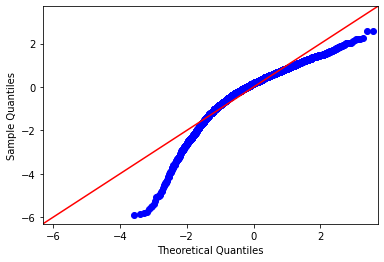

In [69]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

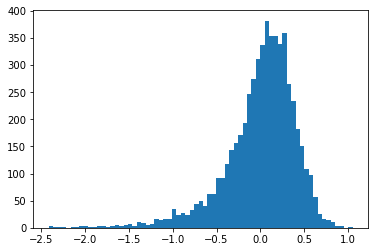

In [70]:
plt.hist(residuals, bins='auto');

# Transform

In [36]:
df_log = model_out.copy()

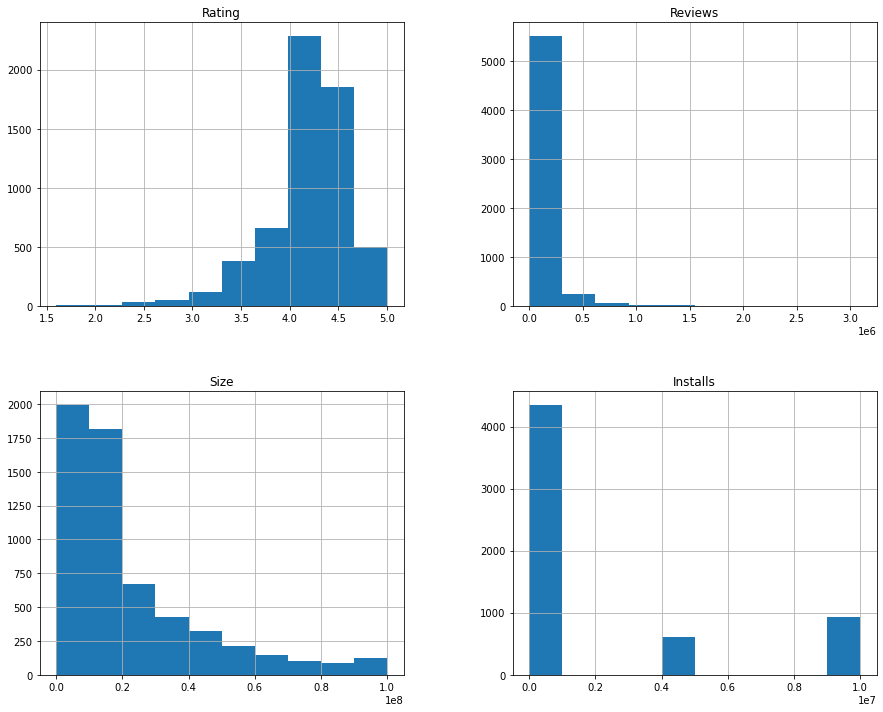

In [38]:
df_log[['Rating', 'Reviews', 'Size', 'Installs']].hist(figsize=(15,12));

All the continuous variable are very skewed. Major outliers with Reviews and Installs. 

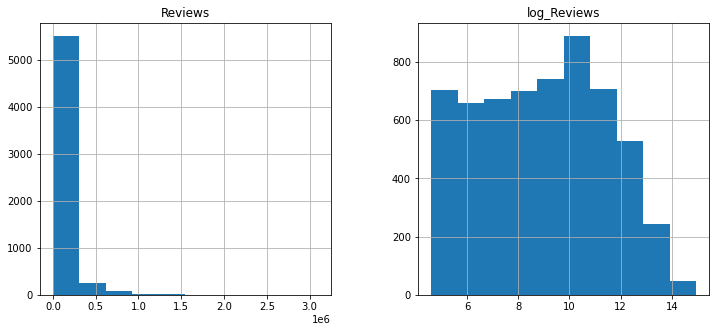

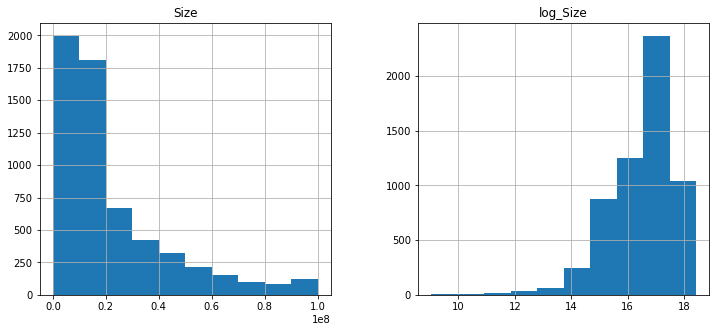

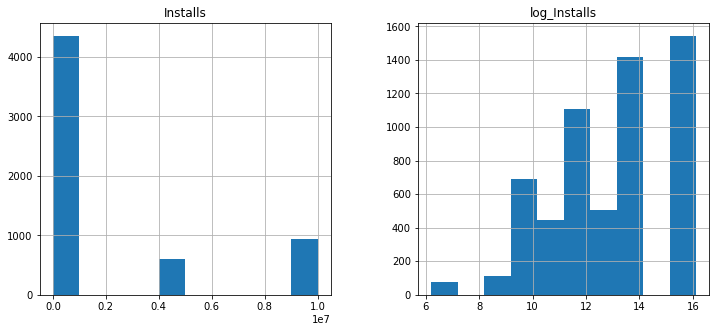

In [39]:
# df_log['log_Rating'] = np.log(df_log['Rating'])
# df_log[['Rating', 'log_Rating']].hist(figsize=(12,5));

df_log['log_Reviews'] = np.log(df_log['Reviews'])
df_log[['Reviews', 'log_Reviews']].hist(figsize=(12,5));

df_log['log_Size'] = np.log(df_log['Size'])
df_log[['Size', 'log_Size']].hist(figsize=(12,5));

df_log['log_Installs'] = np.log(df_log['Installs'])
df_log[['Installs', 'log_Installs']].hist(figsize=(12,5));

In [40]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

In [41]:
df_log_norm = df_log[['log_Installs', 'log_Size', 'log_Reviews']]

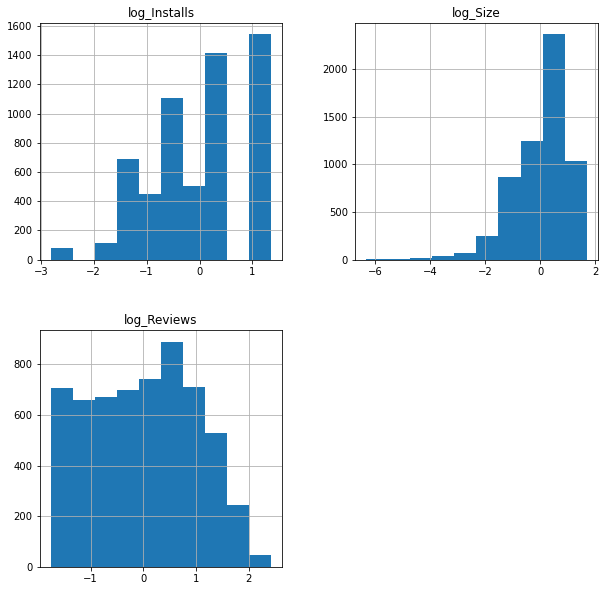

In [42]:
df_log_norm = df_log_norm.apply(normalize)
df_log_norm.hist(figsize=(10,10));

In [43]:
df_log['log_Installs'] = df_log_norm['log_Installs']
df_log['log_Size'] = df_log_norm['log_Size']
df_log['log_Reviews'] = df_log_norm['log_Reviews']

In [44]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5898 entries, 0 to 9066
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Rating                        5898 non-null   float64
 1   Reviews                       5898 non-null   float64
 2   Size                          5898 non-null   float64
 3   Installs                      5898 non-null   int64  
 4   Category_AUTO_AND_VEHICLES    5898 non-null   uint8  
 5   Category_BEAUTY               5898 non-null   uint8  
 6   Category_BOOKS_AND_REFERENCE  5898 non-null   uint8  
 7   Category_BUSINESS             5898 non-null   uint8  
 8   Category_COMICS               5898 non-null   uint8  
 9   Category_COMMUNICATION        5898 non-null   uint8  
 10  Category_DATING               5898 non-null   uint8  
 11  Category_EDUCATION            5898 non-null   uint8  
 12  Category_ENTERTAINMENT        5898 non-null   uint8  
 13  Cat

In [45]:
df_log = df_log.drop(['Reviews', 'Installs', 'Size'], axis=1)

# Linear Regression

In [46]:
outcome = 'Rating'
predictors = df_log.drop(['Rating'], axis=1)
pred_sum = '+'.join(predictors.columns)
f = outcome + '~' + pred_sum
model = ols(f, df_log).fit()
print(f'List of predictors: {pred_sum}')
display(model.summary())

List of predictors: Category_AUTO_AND_VEHICLES+Category_BEAUTY+Category_BOOKS_AND_REFERENCE+Category_BUSINESS+Category_COMICS+Category_COMMUNICATION+Category_DATING+Category_EDUCATION+Category_ENTERTAINMENT+Category_EVENTS+Category_FAMILY+Category_FINANCE+Category_FOOD_AND_DRINK+Category_GAME+Category_HEALTH_AND_FITNESS+Category_HOUSE_AND_HOME+Category_LIBRARIES_AND_DEMO+Category_LIFESTYLE+Category_MAPS_AND_NAVIGATION+Category_MEDICAL+Category_NEWS_AND_MAGAZINES+Category_PARENTING+Category_PERSONALIZATION+Category_PHOTOGRAPHY+Category_PRODUCTIVITY+Category_SHOPPING+Category_SOCIAL+Category_SPORTS+Category_TOOLS+Category_TRAVEL_AND_LOCAL+Category_VIDEO_PLAYERS+Category_WEATHER+Type_Paid+Content_Rating_Everyone+Content_Rating_Everyone_10+Content_Rating_Mature_17+Content_Rating_Teen+Content_Rating_Unrated+Month_Aug+Month_Dec+Month_Feb+Month_Jan+Month_Jul+Month_Jun+Month_Mar+Month_May+Month_Nov+Month_Oct+Month_Sep+log_Reviews+log_Size+log_Installs


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     28.41
Date:                Sat, 03 Apr 2021   Prob (F-statistic):          1.36e-242
Time:                        22:23:48   Log-Likelihood:                -2743.0
No. Observations:                5898   AIC:                             5592.
Df Residuals:                    5845   BIC:                             5946.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.4494      0.234     18.997      0.000       3.990       4.909
Category_AUTO_AND_VEHICLES      -0.0675      0.075     -0.895      0.371      -0.215       0.080
Category_BEAUTY                 -0.0161      0.087     -0.184      0.854      -0.187       0.155
Category_BOOKS_AND_REFERENCE    -0.0312      0.065     -0.478      0.633      -0.159       0.097
Category_BUSINESS               -0.2662      0.064     -4.189      0.000      -0.391      -0.142
Category_COMICS                 -0.2651      0.079     -3.357      0.001      -0.420      -0.110
Category_COMMUNICATION          -0.3560      0.062     -5.717      0.000      -0.478      -0.234
Category_DATING                 -0.4234      0.073     -5.826      0.000      -0.566      -0.281
Category_EDUCATION              -0.1090      0.065     -1.667      0.096      -0.237       0.019
Category_ENTERTAINMENT          -0.3544      0.069     -5.161      0.000      -0.489      -0.220
Category_EVENTS                 -0.0799      0.092     -0.865      0.387      -0.261       0.101
Category_FAMILY                 -0.2840      0.056     -5.097      0.000      -0.393      -0.175
Category_FINANCE                -0.3280      0.060     -5.435      0.000      -0.446      -0.210
Category_FOOD_AND_DRINK         -0.2550      0.069     -3.692      0.000      -0.390      -0.120
Category_GAME                   -0.2819      0.057     -4.943      0.000      -0.394      -0.170
Category_HEALTH_AND_FITNESS     -0.1942      0.061     -3.182      0.001      -0.314      -0.075
Category_HOUSE_AND_HOME         -0.2434      0.074     -3.307      0.001      -0.388      -0.099
Category_LIBRARIES_AND_DEMO     -0.1806      0.079     -2.287      0.022      -0.335      -0.026
Category_LIFESTYLE              -0.3735      0.061     -6.148      0.000      -0.493      -0.254
Category_MAPS_AND_NAVIGATION    -0.3410      0.069     -4.950      0.000      -0.476      -0.206
Category_MEDICAL                -0.2076      0.064     -3.268      0.001      -0.332      -0.083
Category_NEWS_AND_MAGAZINES     -0.3586      0.063     -5.671      0.000      -0.483      -0.235
Category_PARENTING              -0.0347      0.081     -0.427      0.670      -0.194       0.125
Category_PERSONALIZATION        -0.1478      0.061     -2.420      0.016      -0.267      -0.028
Category_PHOTOGRAPHY            -0.3092      0.062     -5.021      0.000      -0.430      -0.188
Category_PRODUCTIVITY           -0.2236      0.061     -3.663      0.000      -0.343      -0.104
Category_SHOPPING               -0.2599      0.063     -4.096      0.000      -0.384      -0.136
Category_SOCIAL                 -0.1979      0.064     -3.080      0.002      -0.324      -0.072
Category_SPORTS                 -0.2597      0.061     -4.289      0.000    

In [47]:
y = df_log['Rating']
X = df_log.drop('Rating', axis=1)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(len(X_train), len(X_test), len(y_train), len(y_test))

4423 1475 4423 1475


In [50]:
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('MAE:', mean_absolute_error(y_test, y_hat_test))
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)
print('Root Mean Squared Error Train:', rmse_train)
print('Root Mean Squared Error Test:', rmse_test)

MAE: 0.28011569924508145
Train Mean Squared Error: 0.14929243253567714
Test Mean Squared Error: 0.14775901401978705
Root Mean Squared Error Train: 0.38638378917298943
Root Mean Squared Error Test: 0.3843943470185105


<ipython-input-51-8c4a1944e451>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


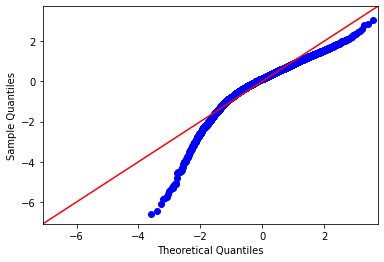

In [51]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

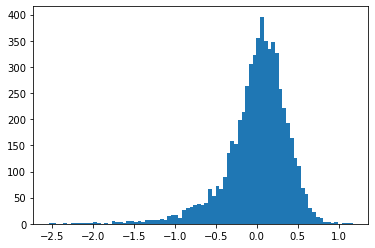

In [52]:
plt.hist(residuals, bins='auto');

# KNeighbors Regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
model = KNeighborsRegressor(n_neighbors=200,weights='distance')
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

In [ ]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print('MAE:', mean_absolute_error(y_test, y_pred))
print('Train Mean Squared Error:', mse_train)
print('Test Mean Squared Error:', mse_test)
print('Root Mean Squared Error Train:', rmse_train)
print('Root Mean Squared Error Test:', rmse_test)

# Random Forest